# CSE 4510 Activity 3
## Topic: Apache Spark DataFrames
**Name: Autumn Monsees** | Due Date: 11/5/2022

### Preamble
Import packages

In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, functions
from pyspark.sql.types import *
from pyspark.pandas import DataFrame
import requests
from pprint import pprint
from datetime import datetime
import pandas as pd

### Question 1 - Data Cleaning
**a) Create a parallelized Spark Context (local[\*]) and use it to complete the assignment.**

In [2]:
sc = SparkContext('local[*]')

**b) Read the dataset using 0.1% sampling ratio to infer the schema.**

In [3]:
session = SparkSession.builder\
            .master('local')\
            .appName("Calls Processor")\
            .getOrCreate()

In [4]:
data = session.read\
        .option("header", True)\
        .option("samplingRatio", 0.001)\
        .csv("Fire_Department_Calls_for_Service.csv")

In [5]:
data.printSchema()

root
 |-- Call Number: string (nullable = true)
 |-- Unit ID: string (nullable = true)
 |-- Incident Number: string (nullable = true)
 |-- Call Type: string (nullable = true)
 |-- Call Date: string (nullable = true)
 |-- Watch Date: string (nullable = true)
 |-- Received DtTm: string (nullable = true)
 |-- Entry DtTm: string (nullable = true)
 |-- Dispatch DtTm: string (nullable = true)
 |-- Response DtTm: string (nullable = true)
 |-- On Scene DtTm: string (nullable = true)
 |-- Transport DtTm: string (nullable = true)
 |-- Hospital DtTm: string (nullable = true)
 |-- Call Final Disposition: string (nullable = true)
 |-- Available DtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode of Incident: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- Station Area: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- Original Priority: string (nullable = true)
 |-- Priority: string (nullable = 

**c) Create a new column named Delay, which is the difference in minutes (rounded to 2DP) between Response DtTm and Received DtTm.  Display the Response DtTm, Received DtTm, and Delay for the record with CallNumber 203350320**

View the Response & Received DtTm

In [6]:
print(data.head()["Response DtTm"])
print(data.head()["Received DtTm"])

05/01/2022 03:01:06 AM
05/01/2022 02:58:25 AM


Get the difference between them

In [7]:
format_str = "MM/dd/yyyy hh:mm:ss a"
delay_seconds = (functions.unix_timestamp("Response DtTm", format_str)\
                 - functions.unix_timestamp("Received DtTm", format_str))/60

In [8]:
with_delay = data.withColumn("Delay", functions.round(delay_seconds,2))

Fetch Response DtTm, Received DtTm, Delay for CallNumber = 203350320

In [9]:
query = with_delay.where(with_delay["Call Number"]== "203350320")\
            .select("Call Number", "Response DtTm", "Received DtTm", "Delay")

In [10]:
query.show()

+-----------+--------------------+--------------------+-----+
|Call Number|       Response DtTm|       Received DtTm|Delay|
+-----------+--------------------+--------------------+-----+
|  203350320|11/30/2020 06:24:...|11/30/2020 06:21:...| 2.85|
|  203350320|                null|11/30/2020 06:21:...| null|
|  203350320|                null|11/30/2020 06:21:...| null|
|  203350320|11/30/2020 06:23:...|11/30/2020 06:21:...|  2.7|
|  203350320|11/30/2020 06:22:...|11/30/2020 06:21:...| 1.52|
+-----------+--------------------+--------------------+-----+



**d) Drop the following columns from the dataset and arrange the data such that the same schema from
the tutorial given in class can be used to read the dataset: Received DtTm, Entry DtTm, Dispatch DtTm,
Response DtTm, On Scene DtTm, Transport DtTm, Hospital DtTm**

In [11]:
revised = with_delay.drop("Received DtTm", "Entry DtTm", "Dispatch DtTm", "Response DtTm",\
                          "On Scene DtTm", "Transport DtTm", "Hospital DtTm")

In [12]:
revised.printSchema()

root
 |-- Call Number: string (nullable = true)
 |-- Unit ID: string (nullable = true)
 |-- Incident Number: string (nullable = true)
 |-- Call Type: string (nullable = true)
 |-- Call Date: string (nullable = true)
 |-- Watch Date: string (nullable = true)
 |-- Call Final Disposition: string (nullable = true)
 |-- Available DtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode of Incident: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- Station Area: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- Original Priority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- Final Priority: string (nullable = true)
 |-- ALS Unit: string (nullable = true)
 |-- Call Type Group: string (nullable = true)
 |-- Number of Alarms: string (nullable = true)
 |-- Unit Type: string (nullable = true)
 |-- Unit sequence in call dispatch: string (nullable = true)
 |-- Fire Prevention Di

Let's get the schema for reference

In [13]:
final_schema = StructType([
    StructField('CallNumber', IntegerType(), True),
    StructField('UnitID', StringType(), True),
    StructField('IncidentNumber', IntegerType(), True),
    StructField('CallType', StringType(), True),
    StructField('CallDate', StringType(), True),
    StructField('WatchDate', StringType(), True),
    StructField('CallFinalDisposition', StringType(), True),
    StructField('AvailableDtTm', StringType(), True),
    StructField('Address', StringType(), True),
    StructField('City', StringType(), True),
    StructField('Zipcode', IntegerType(), True),
    StructField('Battalion', StringType(), True),
    StructField('StationArea', StringType(), True),
    StructField('Box', StringType(), True),
    StructField('OriginalPriority', StringType(), True),
    StructField('Priority', StringType(), True),
    StructField('FinalPriority', IntegerType(), True),
    StructField('ALSUnit', BooleanType(), True),
    StructField('CallTypeGroup', StringType(), True),
    StructField('NumAlarms', IntegerType(), True),
    StructField('UnitType', StringType(), True),
    StructField('UnitSequenceInCallDispatch', IntegerType(), True),
    StructField('FirePreventionDistrict', StringType(), True),
    StructField('SupervisorDistrict', StringType(), True),
    StructField('Neighborhood', StringType(), True),
    StructField('Location', StringType(), True),
    StructField('RowID', StringType(), True),
    StructField('Delay', FloatType(), True)
])

In [14]:
renamed = revised\
        .withColumn("CallNumber", revised["Call Number"].cast(IntegerType()))\
        .withColumnRenamed("Unit ID", "UnitID")\
        .withColumn("IncidentNumber", revised["Incident Number"].cast(IntegerType()))\
        .withColumnRenamed("Call Type", "CallType")\
        .withColumnRenamed("Call Date", "CallDate")\
        .withColumnRenamed("Watch Date", "WatchDate")\
        .withColumnRenamed("Call Final Disposition", "CallFinalDisposition")\
        .withColumnRenamed("Available DtTm", "AvailableDtTm")\
        .withColumnRenamed("Address", "Address")\
        .withColumnRenamed("City", "City")\
        .withColumn("Zipcode", revised["Zipcode of Incident"].cast(IntegerType()))\
        .withColumnRenamed("Battalion", "Battalion")\
        .withColumnRenamed("Station Area", "StationArea")\
        .withColumnRenamed("Box", "Box")\
        .withColumnRenamed("Original Priority", "OriginalPriority")\
        .withColumnRenamed("Priority", "Priority")\
        .withColumn("FinalPriority", revised["Final Priority"].cast(IntegerType()))\
        .withColumn("ALSUnit", revised["ALS Unit"].cast(BooleanType()))\
        .withColumnRenamed("Call Type Group", "CallTypeGroup")\
        .withColumn("NumAlarms", revised["Number of Alarms"].cast(IntegerType()))\
        .withColumnRenamed("Unit Type", "UnitType")\
        .withColumn("UnitSequenceInCallDispatch", revised["Unit sequence in call dispatch"].cast(IntegerType()))\
        .withColumnRenamed("Fire Prevention District", "FirePreventionDistrict")\
        .withColumnRenamed("Supervisor District", "SupervisorDistrict")\
        .withColumnRenamed("Neighborhooods - Analysis Boundaries", "Neighborhood")\
        .withColumnRenamed("Analysis Neighborhood", "AnalysisNeighborhood")\
        .withColumnRenamed("case_location", "Location")\
        .withColumnRenamed("RowID", "RowID")\
        .withColumnRenamed("Delay", "Delay")

In [15]:
renamed.printSchema()

root
 |-- Call Number: string (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- Incident Number: string (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode of Incident: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- Final Priority: string (nullable = true)
 |-- ALS Unit: string (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- Number of Alarms: string (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- Unit sequence in call dispatch: string (nullable = true)
 |-- FirePreventionDistrict: string

Still some out of order, so we'll reorder them with select()

In [16]:
reordered = renamed.select(
    'CallNumber',
    'UnitID',
    'IncidentNumber',
    'CallType',
    'CallDate',
    'WatchDate',
    'CallFinalDisposition',
    'AvailableDtTm',
    'Address',
    'City',
    'Zipcode',
    'Battalion',
    'StationArea',
    'Box',
    'OriginalPriority',
    'Priority',
    'FinalPriority',
    'ALSUnit',
    'CallTypeGroup',
    'NumAlarms',
    'UnitType',
    'UnitSequenceInCallDispatch',
    'FirePreventionDistrict',
    'SupervisorDistrict',
    'Neighborhood',
    'Location',
    'RowID',
    'Delay'
)

In [17]:
reordered.printSchema()

root
 |-- CallNumber: integer (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: integer (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: integer (nullable = true)
 |-- ALSUnit: boolean (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- NumAlarms: integer (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- UnitSequenceInCallDispatch: integer (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 

**e) Save the modified dataset with only the columns featured in the in-class tutorial to a single CSV file**

In [18]:
reordered.coalesce(1).write.csv("Ordered_Fire_Department_Calls_With_Delay.csv", mode='overwrite')

![save_success.png](save_success.png)

**f) Read the updated dataset using the schema provided in the in-class tutorial**

For the sake of convenience, I am renaming and moving the csv

In [19]:
data_read = session.read.csv("Ordered_Fire_Department_Calls_With_Delay.csv", schema=final_schema,header=True)

In [20]:
data_read.head()

Row(CallNumber=220190150, UnitID='E29', IncidentNumber=22008871, CallType='Alarms', CallDate='01/19/2022', WatchDate='01/18/2022', CallFinalDisposition='Fire', AvailableDtTm='01/19/2022 02:35:26 AM', Address='100 Block of MISSISSIPPI ST', City='San Francisco', Zipcode=94107, Battalion='B03', StationArea='29', Box='2431', OriginalPriority='3', Priority='3', FinalPriority=3, ALSUnit=True, CallTypeGroup='Alarm', NumAlarms=1, UnitType='ENGINE', UnitSequenceInCallDispatch=1, FirePreventionDistrict='3', SupervisorDistrict='10', Neighborhood='Potrero Hill', Location='POINT (-122.39469970274361 37.76460987856451)', RowID='220190150-E29', Delay=4.579999923706055)

**g) Return a list of 10 Distinct Call Types**

In [21]:
query = data_read.select('CallType').where(data_read['CallType'].isNotNull()).distinct()

In [22]:
query.show(10, False)

+-----------------------------------+
|CallType                           |
+-----------------------------------+
|Elevator / Escalator Rescue        |
|Marine Fire                        |
|Aircraft Emergency                 |
|Confined Space / Structure Collapse|
|Administrative                     |
|Alarms                             |
|Odor (Strange / Unknown)           |
|Citizen Assist / Service Call      |
|HazMat                             |
|Watercraft in Distress             |
+-----------------------------------+
only showing top 10 rows



**h) Return a count of Distinct Call Types**


In [23]:
data_read.select("CallType")\
         .where(data_read["CallType"].isNotNull())\
         .agg(functions.countDistinct("CallType").alias("DistinctCallTypes"))\
         .show()

+-----------------+
|DistinctCallTypes|
+-----------------+
|               32|
+-----------------+



**i) Rename the Delay column to ResponseDelayedinMins and return the top 5 records (sorted by ResponseDelayedinMins in descending order) where ResponseDelayedinMins > 5 (Show only the ResponseDelayedinMins column in your output)**

In [24]:
renamed_delay = data_read.withColumnRenamed("Delay", "ResponseDelayedinMins")

In [25]:
renamed_delay.select("ResponseDelayedinMins")\
                .where("ResponseDelayedinMins > 5")\
                .orderBy("ResponseDelayedinMins", ascending=False)\
                .show(5)

+---------------------+
|ResponseDelayedinMins|
+---------------------+
|              2465.28|
|              2234.07|
|              2176.63|
|              1997.77|
|              1879.62|
+---------------------+
only showing top 5 rows



**j) Return a list of the top 10 delayed Fire Responses sorted in descending order and showing the Call Type,
Address (Full address in title-case in one column including City and Zip Code), Battalion, ResponseDelayedinMins,
and Unit Type**

We need to get the full address

In [26]:
def get_address(address, city, zipcode):
    return f"{address}, {city} {zipcode}".title()

In [27]:
address = renamed_delay.select(functions.udf(get_address)("Address", "City", "Zipcode").alias("FullAddress"))

In [28]:
address.show(5, False)

+------------------------------------------------+
|FullAddress                                     |
+------------------------------------------------+
|100 Block Of Mississippi St, San Francisco 94107|
|0 Block Of Hoff St, San Francisco 94110         |
|200 Block Of Jones St, San Francisco 94102      |
|1400 Block Of Filbert St, San Francisco 94109   |
|500 Block Of Jones St, San Francisco 94102      |
+------------------------------------------------+
only showing top 5 rows



Now that we can get the full address in one column, we can get the full query

CallType, FullAddress, Battalion, ResponseDelayedinMins, UnitType

In [29]:
renamed_delay.select(
    "CallType",
    functions.udf(get_address)("Address", "City", "Zipcode").alias("FullAddress"),
    "Battalion",
    "ResponseDelayedinMins",
    "UnitType"
    )\
    .orderBy("ResponseDelayedinMins", ascending=False)\
    .show(10)

+--------------------+--------------------+---------+---------------------+-------------+
|            CallType|         FullAddress|Battalion|ResponseDelayedinMins|     UnitType|
+--------------------+--------------------+---------+---------------------+-------------+
|      Structure Fire|200 Block Of Jeff...|      B01|              2465.28|       ENGINE|
|      Structure Fire|200 Block Of Jeff...|      B01|              2234.07|       ENGINE|
|Mutual Aid / Assi...|Blue Ridge Fire, ...|      B06|              2176.63|       ENGINE|
|      Structure Fire|200 Block Of Jeff...|      B01|              1997.77|       ENGINE|
|      Structure Fire|1300 Block Of Mis...|      B02|              1879.62|       ENGINE|
|              Alarms|0 Block Of 6Th St...|      B02|              1844.55|INVESTIGATION|
|      Structure Fire|200 Block Of Jeff...|      B01|               1793.2|       ENGINE|
|      Structure Fire|200 Block Of Jeff...|      B01|              1769.47|       ENGINE|
|      Str

**k) Create a horizontal bar chart of the top 10 delayed Fire Responses (ResponseDelayedinMins vs Call
Number)**

Get our x and y values

In [30]:
bar_chart_fields = renamed_delay.select("ResponseDelayedinMins", "CallNumber")\
                        .orderBy("ResponseDelayedinMins", ascending=False)\
                        .limit(10)

In [31]:
bar_chart_fields.show()

+---------------------+----------+
|ResponseDelayedinMins|CallNumber|
+---------------------+----------+
|              2465.28| 201440320|
|              2234.07| 201440320|
|              2176.63| 203020714|
|              1997.77| 201440320|
|              1879.62|   2920036|
|              1844.55| 171580719|
|               1793.2| 201440320|
|              1769.47| 201440320|
|              1739.43|  92420136|
|              1683.83| 202100407|
+---------------------+----------+



Convert values to pandas dataframe to plot

In [32]:
pd_bar = bar_chart_fields.toPandas()

In [33]:
pd_bar

,ResponseDelayedinMins,CallNumber
0,2465.280029,201440320
1,2234.070068,201440320
2,2176.629883,203020714
3,1997.770020,201440320
4,1879.619995,2920036
5,1844.550049,171580719
6,1793.199951,201440320
7,1769.469971,201440320
8,1739.430054,92420136
9,1683.829956,202100407


Plot

<AxesSubplot:xlabel='CallNumber'>

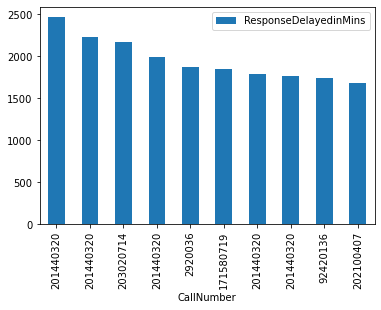

In [34]:
pd_bar.plot.bar('CallNumber','ResponseDelayedinMins')

**l) Convert the following fields to date: CallDate, WatchDate, AvailableDtTm**

Take a look at the format

In [35]:
renamed_delay.select("CallDate", "WatchDate", "AvailableDtTm").show(5, False)

+----------+----------+----------------------+
|CallDate  |WatchDate |AvailableDtTm         |
+----------+----------+----------------------+
|01/19/2022|01/18/2022|01/19/2022 02:35:26 AM|
|05/03/2021|05/03/2021|05/03/2021 09:38:09 PM|
|10/20/2021|10/20/2021|10/20/2021 10:25:52 PM|
|04/30/2022|04/30/2022|04/30/2022 06:40:08 PM|
|05/03/2021|05/03/2021|05/03/2021 05:05:20 PM|
+----------+----------+----------------------+
only showing top 5 rows



Reformat the table

In [36]:
date_format = "MM/dd/yyyy"
dttm_format = "MM/dd/yyyy hh:mm:ss a"
date_fields = renamed_delay\
                    .withColumn("IncidentDate", functions.to_date(renamed_delay['CallDate'], date_format))\
                    .drop("CallDate")\
                    .withColumn("OnWatchDate", functions.to_date(renamed_delay['WatchDate'], date_format))\
                    .drop("WatchDate")\
                    .withColumn("AvailableDate", functions.to_date(renamed_delay['AvailableDtTm'], dttm_format))\
                    .drop("AvailableDtTm")

In [37]:
date_fields.select("IncidentDate", "OnWatchDate", "AvailableDate").show(5, False)

+------------+-----------+-------------+
|IncidentDate|OnWatchDate|AvailableDate|
+------------+-----------+-------------+
|2022-01-19  |2022-01-18 |2022-01-19   |
|2021-05-03  |2021-05-03 |2021-05-03   |
|2021-10-20  |2021-10-20 |2021-10-20   |
|2022-04-30  |2022-04-30 |2022-04-30   |
|2021-05-03  |2021-05-03 |2021-05-03   |
+------------+-----------+-------------+
only showing top 5 rows



**l) Show a complete list of the distinct years represented in the dataset based on the IncidentDate**

In [38]:
def get_year(col):
    return col.year

Filter out the years

In [39]:
years = date_fields.select(functions.udf(get_year)('IncidentDate').alias("Years"))

How many unique years?

In [40]:
years_counts = years.select("Years")\
                 .where(years["Years"].isNotNull())\
                 .agg(functions.countDistinct("Years").alias("UniqueYearCount"))\
                 .show()

+---------------+
|UniqueYearCount|
+---------------+
|             23|
+---------------+



Get all the unique years

In [41]:
years.select("Years").where(years["Years"].isNotNull()).distinct().show(23)

+-----+
|Years|
+-----+
| 2016|
| 2020|
| 2005|
| 2000|
| 2002|
| 2009|
| 2018|
| 2006|
| 2004|
| 2022|
| 2008|
| 2007|
| 2021|
| 2001|
| 2010|
| 2012|
| 2019|
| 2017|
| 2014|
| 2013|
| 2011|
| 2015|
| 2003|
+-----+



### Question 2 - EDA

**a) Create a MonthYear Column in the dataset of the format YYYYMM (eg: 202209) based on the IncidentDate**

In [42]:
def month_year(row):
    return f"{row.year}{row.month:02}"

In [43]:
with_month_year = date_fields.withColumn("MonthYear",
                                         functions.udf(month_year)("IncidentDate"))

In [44]:
with_month_year.select("IncidentDate", "MonthYear").show()

+------------+---------+
|IncidentDate|MonthYear|
+------------+---------+
|  2022-01-19|   202201|
|  2021-05-03|   202105|
|  2021-10-20|   202110|
|  2022-04-30|   202204|
|  2021-05-03|   202105|
|  2021-07-13|   202107|
|  2021-10-20|   202110|
|  2022-04-30|   202204|
|  2021-07-13|   202107|
|  2022-01-18|   202201|
|  2022-01-11|   202201|
|  2022-01-11|   202201|
|  2022-01-11|   202201|
|  2022-01-18|   202201|
|  2022-04-30|   202204|
|  2021-07-13|   202107|
|  2022-01-18|   202201|
|  2022-07-28|   202207|
|  2022-07-28|   202207|
|  2022-04-30|   202204|
+------------+---------+
only showing top 20 rows



**b) Create an in-memory DataFrame that stores the Temperature and the MonthYear from Global Summary of the Month (GSOM) data dynamically harvested from the NOAA API from the weather station located Downtown, San Francisco.**

Set API parameters for later use

In [45]:
with open("noaa_token.txt", 'r') as f:
    api_key = f.read()
headers = {"token": api_key}
limit = 24 * 12 # 23 (+1 for good measure) years from 2000-2022 including endpoints, one temp per month

Lets find the state

In [46]:
datasets_query_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=ST"
response = requests.get(datasets_query_url, headers=headers)

In [47]:
def read_json_response(response):
    if response.status_code == 200:
        data = response.json()
        #print(f"Found: {data['metadata']['resultset']['count']} responses")
        pprint(data)

In [48]:
read_json_response(response)

{'metadata': {'resultset': {'count': 51, 'limit': 25, 'offset': 1}},
 'results': [{'datacoverage': 1,
              'id': 'FIPS:01',
              'maxdate': '2022-11-05',
              'mindate': '1888-02-01',
              'name': 'Alabama'},
             {'datacoverage': 1,
              'id': 'FIPS:02',
              'maxdate': '2022-11-05',
              'mindate': '1893-09-01',
              'name': 'Alaska'},
             {'datacoverage': 1,
              'id': 'FIPS:04',
              'maxdate': '2022-11-05',
              'mindate': '1867-08-01',
              'name': 'Arizona'},
             {'datacoverage': 1,
              'id': 'FIPS:05',
              'maxdate': '2022-11-05',
              'mindate': '1871-07-01',
              'name': 'Arkansas'},
             {'datacoverage': 1,
              'id': 'FIPS:06',
              'maxdate': '2022-11-05',
              'mindate': '1850-10-01',
              'name': 'California'},
             {'datacoverage': 1,
              '

California has an id of FIPS:06

Next, pull the stations

In [49]:
datasets_query_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/stations?datasetid=GSOM&locationid=FIPS:06&sortfield=name&sortorder=desc&limit=750"
response = requests.get(datasets_query_url, headers=headers)

In [50]:
read_json_response(response)

{'metadata': {'resultset': {'count': 2827, 'limit': 750, 'offset': 1}},
 'results': [{'datacoverage': 0.9833,
              'elevation': 150.9,
              'elevationUnit': 'METERS',
              'id': 'GHCND:USR0000CYUR',
              'latitude': 41.2897,
              'longitude': -123.8575,
              'maxdate': '2022-09-01',
              'mindate': '2002-11-01',
              'name': 'YUROK CALIFORNIA, CA US'},
             {'datacoverage': 0.9888,
              'elevation': 73.2,
              'elevationUnit': 'METERS',
              'id': 'GHCND:USW00093145',
              'latitude': 32.73333,
              'longitude': -114.61667,
              'maxdate': '1974-04-01',
              'mindate': '1893-01-01',
              'name': 'YUMA WEATHER BUREAU CITY, CA US'},
             {'datacoverage': 1,
              'elevation': 990.3,
              'elevationUnit': 'METERS',
              'id': 'GHCND:USC00049888',
              'latitude': 34.1294,
              'longitude'

              'name': 'TRAVIS FIELD AFB, CA US'},
             {'datacoverage': 1,
              'elevation': 3,
              'elevationUnit': 'METERS',
              'id': 'GHCND:USC00048996',
              'latitude': 37.78333,
              'longitude': -121.43333,
              'maxdate': '1951-09-01',
              'mindate': '1948-07-01',
              'name': 'TRACY, CA US'},
             {'datacoverage': 0.9828,
              'elevation': 18.6,
              'elevationUnit': 'METERS',
              'id': 'GHCND:USC00049001',
              'latitude': 37.79589,
              'longitude': -121.58319,
              'maxdate': '2022-09-01',
              'mindate': '1955-02-01',
              'name': 'TRACY PUMPING PLANT, CA US'},
             {'datacoverage': 0.6717,
              'elevation': 41.1,
              'elevationUnit': 'METERS',
              'id': 'GHCND:USC00048999',
              'latitude': 37.6819,
              'longitude': -121.3466,
              'maxdate': '20

              'id': 'GHCND:USR0000CSHQ',
              'latitude': 36.5672,
              'longitude': -118.9556,
              'maxdate': '2022-09-01',
              'mindate': '1990-05-01',
              'name': 'SHADEQUARTER CALIFORNIA, CA US'},
             {'datacoverage': 0.9027,
              'elevation': 1549,
              'elevationUnit': 'METERS',
              'id': 'GHCND:USC00048105',
              'latitude': 34.18333,
              'longitude': -116.95,
              'maxdate': '1955-03-01',
              'mindate': '1909-12-01',
              'name': 'SEVEN OAKS, CA US'},
             {'datacoverage': 1,
              'elevation': 207.3,
              'elevationUnit': 'METERS',
              'id': 'GHCND:USC00048092',
              'latitude': 34.1661,
              'longitude': -118.4736,
              'maxdate': '1960-06-01',
              'mindate': '1948-07-01',
              'name': 'SEPULVEDA DAM, CA US'},
             {'datacoverage': 0.9542,
              'elev

              'latitude': 38.627077,
              'longitude': -121.373998,
              'maxdate': '2022-09-01',
              'mindate': '2017-07-01',
              'name': 'SACRAMENTO 6.5 NE, CA US'},
             {'datacoverage': 0.4472,
              'elevation': 8.5,
              'elevationUnit': 'METERS',
              'id': 'GHCND:US1CASA0023',
              'latitude': 38.492779,
              'longitude': -121.419475,
              'maxdate': '2012-09-01',
              'mindate': '2009-08-01',
              'name': 'SACRAMENTO 5.7 SSE, CA US'},
             {'datacoverage': 0.1249,
              'elevation': 14.3,
              'elevationUnit': 'METERS',
              'id': 'GHCND:US1CASA0057',
              'latitude': 38.562516,
              'longitude': -121.37125,
              'maxdate': '2021-02-01',
              'mindate': '2019-03-01',
              'name': 'SACRAMENTO 5.2 E, CA US'},
             {'datacoverage': 1,
              'elevation': 19.5,
            

Find out about data types

The station for San Francisco Downtown has a id GHCND:USW00023272

Also, for annual and monthly data, the range is restricted to a 10 year period

In [51]:
station = "GHCND:USW00023272"
start_dates = [f"20{x}0-01-01" for x in range(3)]
end_dates = [f"20{x}9-12-31" for x in range(3)]
print(start_dates)
print(end_dates)

['2000-01-01', '2010-01-01', '2020-01-01']
['2009-12-31', '2019-12-31', '2029-12-31']


In [52]:
monthyears = []
temps = []
for i in range(min(len(start_dates), len(end_dates))):
    downtown_temps_query = "https://www.ncei.noaa.gov/cdo-web/api/v2/data?"\
        f"datasetid=GSOM&stationid={station}&"\
        f"startdate={start_dates[i]}&enddate={end_dates[i]}&"\
        f"datatypeid=TAVG&limit=150"
    response = requests.get(downtown_temps_query,headers=headers)
    data = response.json()
    for r in data['results']:
        monthyears.append(datetime.strptime(r['date'], "%Y-%m-%dT%H:%M:%S").strftime('%Y%m'))
        temps.append(float(r['value']))

In [53]:
monthyears

['200001',
 '200002',
 '200003',
 '200004',
 '200005',
 '200006',
 '200007',
 '200008',
 '200009',
 '200010',
 '200011',
 '200012',
 '200101',
 '200102',
 '200103',
 '200104',
 '200105',
 '200106',
 '200107',
 '200108',
 '200109',
 '200110',
 '200111',
 '200112',
 '200201',
 '200202',
 '200203',
 '200204',
 '200205',
 '200206',
 '200207',
 '200208',
 '200209',
 '200210',
 '200211',
 '200212',
 '200301',
 '200302',
 '200303',
 '200304',
 '200305',
 '200306',
 '200307',
 '200308',
 '200309',
 '200310',
 '200311',
 '200312',
 '200401',
 '200402',
 '200403',
 '200404',
 '200405',
 '200406',
 '200407',
 '200408',
 '200409',
 '200410',
 '200411',
 '200412',
 '200501',
 '200502',
 '200503',
 '200504',
 '200505',
 '200506',
 '200507',
 '200508',
 '200509',
 '200510',
 '200511',
 '200512',
 '200601',
 '200602',
 '200603',
 '200604',
 '200605',
 '200606',
 '200607',
 '200608',
 '200609',
 '200610',
 '200611',
 '200612',
 '200701',
 '200702',
 '200703',
 '200704',
 '200705',
 '200706',
 '200707',

In [54]:
month_year_temp = [[monthyears[i],temps[i]] for i in range(0, min(len(monthyears), len(temps)))]

In [55]:
month_year_temp

[['200001', 11.46],
 ['200002', 12.13],
 ['200003', 12.74],
 ['200004', 13.95],
 ['200005', 14.59],
 ['200006', 15.28],
 ['200007', 14.63],
 ['200008', 15.92],
 ['200009', 18.17],
 ['200010', 15.3],
 ['200011', 12.11],
 ['200012', 12.2],
 ['200101', 10.76],
 ['200102', 11.15],
 ['200103', 13.25],
 ['200104', 11.38],
 ['200105', 16.12],
 ['200106', 16.28],
 ['200107', 15.82],
 ['200108', 16.4],
 ['200109', 16.12],
 ['200110', 17.03],
 ['200111', 14.79],
 ['200112', 11.53],
 ['200201', 10.37],
 ['200202', 13.03],
 ['200203', 11.95],
 ['200204', 12.69],
 ['200205', 12.79],
 ['200206', 14.45],
 ['200207', 15.1],
 ['200208', 15.77],
 ['200209', 16.4],
 ['200210', 15.99],
 ['200211', 15.13],
 ['200212', 12.35],
 ['200301', 13.49],
 ['200302', 12.56],
 ['200303', 13.59],
 ['200304', 12.17],
 ['200305', 14.47],
 ['200306', 15.84],
 ['200307', 15.18],
 ['200308', 17.49],
 ['200309', 18.24],
 ['200310', 17.21],
 ['200311', 12.97],
 ['200312', 11.58],
 ['200401', 10.98],
 ['200402', 12.05],
 ['20

Define the schema and create the df

In [56]:
temp_schema = StructType([
    StructField('MonthYear', StringType(), True),
    StructField('Temperature', FloatType(), True)
])

In [57]:
temps_df = session.createDataFrame(month_year_temp, schema=temp_schema)

In [58]:
temps_df.show()

+---------+-----------+
|MonthYear|Temperature|
+---------+-----------+
|   200001|      11.46|
|   200002|      12.13|
|   200003|      12.74|
|   200004|      13.95|
|   200005|      14.59|
|   200006|      15.28|
|   200007|      14.63|
|   200008|      15.92|
|   200009|      18.17|
|   200010|       15.3|
|   200011|      12.11|
|   200012|       12.2|
|   200101|      10.76|
|   200102|      11.15|
|   200103|      13.25|
|   200104|      11.38|
|   200105|      16.12|
|   200106|      16.28|
|   200107|      15.82|
|   200108|       16.4|
+---------+-----------+
only showing top 20 rows



**c) Augment the dataset with the temperature data and group the data by MonthYear**

In [59]:
joined = with_month_year.join(temps_df, "MonthYear", 'left')

In [60]:
joined.select("IncidentDate", "MonthYear", "Temperature").show()

+------------+---------+-----------+
|IncidentDate|MonthYear|Temperature|
+------------+---------+-----------+
|  2021-10-20|   202110|      16.17|
|  2021-10-20|   202110|      16.17|
|  2021-05-03|   202105|      13.28|
|  2022-04-30|   202204|      13.19|
|  2021-05-03|   202105|      13.28|
|  2022-04-30|   202204|      13.19|
|  2022-04-30|   202204|      13.19|
|  2022-04-30|   202204|      13.19|
|  2021-07-13|   202107|      14.96|
|  2021-07-13|   202107|      14.96|
|  2021-07-13|   202107|      14.96|
|  2022-07-28|   202207|       15.3|
|  2022-07-28|   202207|       15.3|
|  2022-01-19|   202201|      12.22|
|  2022-01-18|   202201|      12.22|
|  2022-01-11|   202201|      12.22|
|  2022-01-11|   202201|      12.22|
|  2022-01-11|   202201|      12.22|
|  2022-01-18|   202201|      12.22|
|  2022-01-18|   202201|      12.22|
+------------+---------+-----------+
only showing top 20 rows



In [61]:
grouped = joined.groupBy("MonthYear")

In [62]:
monthcount = grouped.agg({"*":"count"}).orderBy("MonthYear")\
                .withColumnRenamed("count(1)", "Count")

In [63]:
monthcount.show()

+---------+-----+
|MonthYear|Count|
+---------+-----+
|   200004|10059|
|   200005|18545|
|   200006|18233|
|   200007|18501|
|   200008|18960|
|   200009|19123|
|   200010|18725|
|   200011|17501|
|   200012|18507|
|   200101|18834|
|   200102|16968|
|   200103|19507|
|   200104|17751|
|   200105|19047|
|   200106|18907|
|   200107|18243|
|   200108|18413|
|   200109|16800|
|   200110|19526|
|   200111|17885|
+---------+-----+
only showing top 20 rows



**d) Answer the following question: Is there correlation between the average monthly temperature and the number of fire calls per month?**

In [64]:
corr_df = monthcount.join(temps_df, "MonthYear", 'left')

In [65]:
corr_df.show()

+---------+-----+-----------+
|MonthYear|Count|Temperature|
+---------+-----+-----------+
|   200004|10059|      13.95|
|   200005|18545|      14.59|
|   200006|18233|      15.28|
|   200007|18501|      14.63|
|   200008|18960|      15.92|
|   200009|19123|      18.17|
|   200010|18725|       15.3|
|   200011|17501|      12.11|
|   200012|18507|       12.2|
|   200101|18834|      10.76|
|   200102|16968|      11.15|
|   200103|19507|      13.25|
|   200104|17751|      11.38|
|   200105|19047|      16.12|
|   200106|18907|      16.28|
|   200107|18243|      15.82|
|   200108|18413|       16.4|
|   200109|16800|      16.12|
|   200110|19526|      17.03|
|   200111|17885|      14.79|
+---------+-----+-----------+
only showing top 20 rows



In [66]:
corr_coeff = corr_df.corr("Count", "Temperature")
print("The correlation coefficient is: ", corr_coeff)

The correlation coefficient is:  0.18067151425730443


Because the final correlation coefficient is 0.18067151425730443, we cannot say there is a notable correlation between the temperature and the count of fire department calls.

In [67]:
sc.stop()
session.stop()